In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import gensim

from gensim.models import Word2Vec, KeyedVectors

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re
import matplotlib.pyplot as plt
import nltk

from tensorflow.keras.utils import to_categorical

# Data Preprocessing

In [2]:
data = pd.read_csv("data/news_class.csv")

df = data.copy() # to be safe and avoid errors

df = df.loc[:,["data_id" , "content" , "category_level_1" , "category_level_2"]]
df.groupby(['category_level_1'])['data_id'].agg('count')

category_level_1
arts, culture, entertainment and media        300
conflict, war and peace                       800
crime, law and justice                        500
disaster, accident and emergency incident     500
economy, business and finance                 400
education                                     607
environment                                   600
health                                        700
human interest                                600
labour                                        703
lifestyle and leisure                         300
politics                                      900
religion and belief                           800
science and technology                        800
society                                      1100
sport                                         907
weather                                       400
Name: data_id, dtype: int64

In [3]:
def labeler(dataframe_column):
    encoder=LabelEncoder()
    
    labels = encoder.fit_transform(dataframe_column)
    print(encoder.classes_)
    print("Labels have been created")
    
    return(pd.DataFrame(labels))

In [4]:
# Function for removing ASCII characters
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

# Function for converting to lower case
def make_lower_case(text):
    return text.lower()

# Function for removing stop words

def remove_stop_words(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text =  tokenizer.tokenize(text)
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text


# Function for removing html
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

# Function for removing punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

def lemm_text(text):
    lemm=WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    tokens = text
    return ' '.join([lemm.lemmatize(t) for t in tokens])


def remove_digits(text):
    text = re.sub(r'\d', '', text)
    return text

In [5]:
df['Cleaned'] = df['content'].apply(_removeNonAscii) # applying the above function on our dataset
df['Cleaned'] = df.Cleaned.apply(func = make_lower_case)
df['Cleaned'] = df.Cleaned.apply(func = remove_stop_words)
df['Cleaned'] = df.Cleaned.apply(func = remove_punctuation)
df['Cleaned'] = df.Cleaned.apply(func = remove_html)
df['Cleaned'] = df.Cleaned.apply(func = lemm_text)
df['Cleaned'] = df.Cleaned.apply(func = remove_digits)
df = df.drop('content' , axis =1)

In [6]:
io = df.copy() #

io = io.drop([374]).reset_index(drop=True)
io = io.drop([6527]).reset_index(drop=True)

corpus_full = []
for words in io['Cleaned']:
    corpus_full.append(words.split()) 

# Word2Vec

In [9]:
#model = Word2Vec.load("final_word2vec_model.h3")

In [7]:
model = Word2Vec(sentences=corpus_full, vector_size=600, window=4, min_count=10, sg = 1 , hs = 1)  # skipgram architecture

Our Word2Vec Model , for the dense embeddings needs :4m & 26sec to be created

In [8]:
model.save("final_word2vec_model.h3")

In [10]:
def vectorizer():
    
    
    # Creating a list for storing the vectors ('Description' into vectors)

    word_embeddings = []
    i = 0
    # Reading the each 'Description'
    for line in io['Cleaned']:
        avgword2vec = None
        count = 0
        for word in line.split():
            if word in model.wv.key_to_index:
                count += 1
                if avgword2vec is None:
                    avgword2vec = model.wv[word]
                else:
                    avgword2vec = avgword2vec + model.wv[word]
                
        if avgword2vec is not None:
            avgword2vec = avgword2vec / count
            word_embeddings.append(avgword2vec)
        else:
            print("I found it , the error occurs at line:" , i)
          
        i +=1 

    return(pd.DataFrame(word_embeddings))  # Returning our Data as a Dataframe (aesthetic reasons)

In [11]:
vect = vectorizer()

# Neural Network

In [93]:
from sklearn.metrics import classification_report, confusion_matrix

In [94]:
def get_weights(nn_model):
    
    print("Our Layers are :")
    for layer in nn_model.layers:
        print(layer.name, layer)
        print()
    
    for i in range(1,5):
        if i == 3 :
            print("Sorry but our Dropout Layer doesnt have any weights or biases")
        
        else:
            print("For Our Dense Layer:")
            print("Weights")
            print(nn_model.layers[i].weights)
            print("Bias")
            print(nn_model.layers[i].bias.numpy())
            #print(nn_model.layers[i].bias_initializer)  
            print()
        
    

In [95]:
def FcNN(n_cat):


    fc_input = tf.keras.Input(shape=(600,), name="embs")
    x = tf.keras.layers.Dense(200, activation="leaky_relu")(fc_input)
    x = tf.keras.layers.Dense(360, activation="leaky_relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    fc_out = tf.keras.layers.Dense(n_cat, activation="softmax")(x)

    my_nn= tf.keras.Model(inputs=fc_input, outputs=fc_out, name="News_Classifier")


    opt = tf.keras.optimizers.AdamW(learning_rate =0.007 , beta_1=0.9,
        beta_2=0.999,
        use_ema=True,
        ema_momentum=0.9999)





    my_nn.compile(optimizer = opt , 
                  loss = 'categorical_crossentropy' ,
                  metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])


    return my_nn

In [110]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [111]:
def train_model(nn_model , X_trained , y_trained , n_epochs):
    
    HIST = nn_model.fit(X_trained , y_trained , batch_size = 16 , epochs = n_epochs , validation_split=(0.2) ,verbose =1)


    predictions = np.argmax(nn_model.predict(X_test), axis=-1)
    
    print("Our Predictions")
    print(predictions)


    print(classification_report(y_test.values , predictions))
    
    plot_history(HIST)

## Category Level 1

In [116]:
y1 = labeler(io["category_level_1"])


X = vect.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2,random_state=42)

y_train1 = to_categorical(y_train)

['arts, culture, entertainment and media' 'conflict, war and peace'
 'crime, law and justice' 'disaster, accident and emergency incident'
 'economy, business and finance' 'education' 'environment' 'health'
 'human interest' 'labour' 'lifestyle and leisure' 'politics'
 'religion and belief' 'science and technology' 'society' 'sport'
 'weather']
Labels have been created


In [ ]:
my_nn1st_cat = FcNN(17)

In [ ]:
my_nn1st_cat.summary()

Epoch 1/10
437/437 [==============================] - 2s 4ms/step - loss: 1.2131 - accuracy: 0.9603 - precision: 0.7395 - recall: 0.5019 - val_loss: 1.2038 - val_accuracy: 0.9622 - val_precision: 0.7591 - val_recall: 0.5232
Epoch 2/10
437/437 [==============================] - 2s 4ms/step - loss: 1.0842 - accuracy: 0.9644 - precision: 0.7578 - recall: 0.5792 - val_loss: 1.4738 - val_accuracy: 0.9558 - val_precision: 0.6581 - val_recall: 0.5157
Epoch 3/10
437/437 [==============================] - 2s 4ms/step - loss: 1.0148 - accuracy: 0.9670 - precision: 0.7771 - recall: 0.6168 - val_loss: 1.3607 - val_accuracy: 0.9626 - val_precision: 0.7316 - val_recall: 0.5758
Epoch 4/10
437/437 [==============================] - 2s 3ms/step - loss: 0.9857 - accuracy: 0.9678 - precision: 0.7778 - recall: 0.6345 - val_loss: 1.2040 - val_accuracy: 0.9647 - val_precision: 0.7599 - val_recall: 0.5850
Epoch 5/10
437/437 [==============================] - 2s 3ms/step - loss: 0.8978 - accuracy: 0.9699 - pr

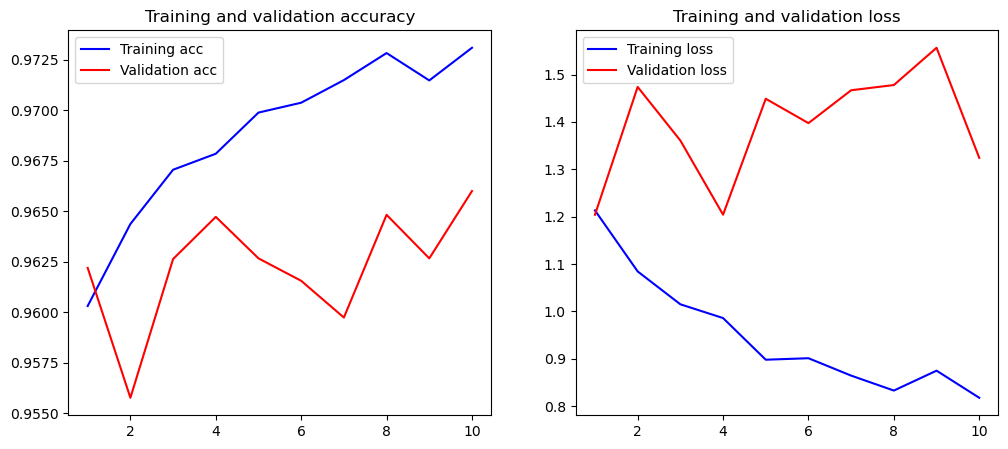

In [117]:
train_model(my_nn1st_cat , X_train , y_train1 , n_epochs = 10)

In [118]:
print("Our finalized Weights and Biases:")
print()
get_weights(my_nn1st_cat)
print()

Our finalized Weights and Biases:

Our Layers are :
embs <keras.src.engine.input_layer.InputLayer object at 0x000001894D3F7610>

dense_68 <keras.src.layers.core.dense.Dense object at 0x0000018910DBAD90>

dense_69 <keras.src.layers.core.dense.Dense object at 0x0000018910DB9A10>

dropout_23 <keras.src.layers.regularization.dropout.Dropout object at 0x000001894D3A96D0>

dense_70 <keras.src.layers.core.dense.Dense object at 0x000001891AF9CE10>

For Our Dense Layer:
Weights
[<tf.Variable 'dense_68/kernel:0' shape=(600, 200) dtype=float32, numpy=
array([[ 0.1260018 , -0.1262861 ,  0.11959726, ..., -0.23542726,
        -0.01872431, -0.31630492],
       [ 0.6296001 ,  0.09857497, -0.26356038, ...,  0.1825013 ,
        -0.19400541, -0.11957788],
       [ 0.23854099,  0.2606957 ,  0.05934649, ..., -0.03137761,
         0.06284125,  0.0162431 ],
       ...,
       [ 0.02524613,  0.00412238, -0.03482511, ..., -0.06906402,
         0.00498768, -0.0487113 ],
       [-0.25836605, -0.09702442, -0.0490

## Category Level 2

In [119]:
y2 = labeler(io["category_level_2"])


X = vect.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.2,random_state=42)

y_train2 = to_categorical(y_train)

['accident and emergency incident' 'accomplishment' 'act of terror'
 'animal' 'anniversary' 'armed conflict' 'arts and entertainment'
 'biomedical science' 'bodybuilding' 'business information' 'ceremony'
 'civil unrest' 'climate change' 'communities' 'competition discipline'
 'conservation' "coup d'etat" 'crime' 'culture' 'demographics' 'disaster'
 'disciplinary action in sport' 'discrimination' 'diseases and conditions'
 'drug use in sport' 'economic sector' 'economy' 'election'
 'emergency incident' 'emergency planning' 'emergency response'
 'emigration' 'employment' 'employment legislation'
 'environmental politics' 'environmental pollution' 'exercise and fitness'
 'family' 'fundamental rights' 'government' 'government policy'
 'health facility' 'health organisations' 'health treatment'
 'healthcare policy' 'immigration' 'international relations'
 'interreligious dialogue' 'judiciary' 'justice' 'labour market'
 'labour relations' 'law' 'law enforcement' 'leisure' 'lifestyle'
 'mank

In [120]:
y_test2 = to_categorical(y_test) # Transoforming our labels to one-hot form ,in order to put them on our NN

In [121]:
my_nn2nd_cat = FcNN(109)

In [122]:
my_nn2nd_cat.summary()

Model: "News_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embs (InputLayer)           [(None, 600)]             0         
                                                                 
 dense_71 (Dense)            (None, 200)               120200    
                                                                 
 dense_72 (Dense)            (None, 360)               72360     
                                                                 
 dropout_24 (Dropout)        (None, 360)               0         
                                                                 
 dense_73 (Dense)            (None, 109)               39349     
                                                                 
Total params: 231909 (905.89 KB)
Trainable params: 231909 (905.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/10
437/437 [==============================] - 3s 5ms/step - loss: 3.2828 - accuracy: 0.9907 - precision: 0.4625 - recall: 0.0838 - val_loss: 3.1325 - val_accuracy: 0.9904 - val_precision: 0.4270 - val_recall: 0.1339
Epoch 2/10
437/437 [==============================] - 2s 4ms/step - loss: 2.5619 - accuracy: 0.9911 - precision: 0.5436 - recall: 0.2105 - val_loss: 2.6383 - val_accuracy: 0.9910 - val_precision: 0.5200 - val_recall: 0.2307
Epoch 3/10
437/437 [==============================] - 2s 4ms/step - loss: 2.3252 - accuracy: 0.9916 - precision: 0.5825 - recall: 0.2846 - val_loss: 2.7452 - val_accuracy: 0.9912 - val_precision: 0.5473 - val_recall: 0.2650
Epoch 4/10
437/437 [==============================] - 2s 4ms/step - loss: 2.2009 - accuracy: 0.9919 - precision: 0.6057 - recall: 0.3278 - val_loss: 2.7239 - val_accuracy: 0.9910 - val_precision: 0.5171 - val_recall: 0.2776
Epoch 5/10
437/437 [==============================] - 2s 4ms/step - loss: 2.0890 - accuracy: 0.9921 - pr

C:\Users\Desktop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Desktop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Desktop\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


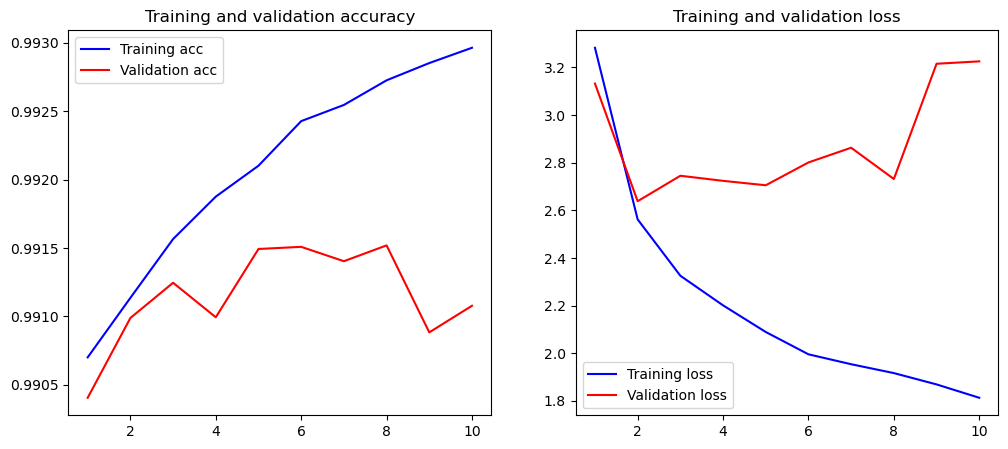

In [123]:
train_model(my_nn2nd_cat , X_train , y_train2 , n_epochs = 10)

In [124]:
print("Our finalized Weights and Biases:")
print()
get_weights(my_nn2nd_cat)
print()

Our finalized Weights and Biases:

Our Layers are :
embs <keras.src.engine.input_layer.InputLayer object at 0x000001893F5ACDD0>

dense_71 <keras.src.layers.core.dense.Dense object at 0x000001894739FC10>

dense_72 <keras.src.layers.core.dense.Dense object at 0x000001892062C850>

dropout_24 <keras.src.layers.regularization.dropout.Dropout object at 0x0000018946A40690>

dense_73 <keras.src.layers.core.dense.Dense object at 0x0000018947462510>

For Our Dense Layer:
Weights
[<tf.Variable 'dense_71/kernel:0' shape=(600, 200) dtype=float32, numpy=
array([[ 0.01628114, -0.12783638,  0.05416873, ...,  0.09147202,
        -0.06439866, -0.08077402],
       [-0.14003932, -0.02308525,  0.01871564, ..., -0.030287  ,
        -0.18068041, -0.04133091],
       [ 0.09630598,  0.05307304, -0.10308494, ...,  0.03240952,
         0.10134651,  0.11557293],
       ...,
       [-0.03200615,  0.01227723, -0.09871424, ..., -0.04937609,
         0.06180078,  0.10179636],
       [-0.01005537,  0.05784618, -0.0047